In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-665f1863-37ec-5517-4112-468fe423de57)


**DOWNLOADING AND PREPROCESSING DATA**

In [2]:
import zipfile
def unzip_data(filename):
  """
  Unzips filename into the current working directory.
  Args:
    filename (str): a filepath to a target zip folder to be unzipped.
  """
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

In [ ]:
import tensorflow as tf

# Download data from Google Storage (already preformatted)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

# Setup data inputs

IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE,
                                                                                batch_size=32)
                                                                                
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False,
                                                                batch_size=32) # don't shuffle test data for prediction analysis

In [5]:
#check the shape of training images and test images
train_data_10_percent, test_data

(<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>,
 <BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>)

MODEL 1: WITHOUT DATA AUGMENTATION

In [10]:
input_shape = (224, 224, 3)

#Setup transfer learning layer and freeze the layers
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False


# CREATE THE MDOEL
inputs = tf.keras.layers.Input(shape = input_shape,name="input_layer")
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs) --> do not need since EfficientNet has it builds in
x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D(name = "GlobalAveragePooling2D_layer")(x)
outputs = tf.keras.layers.Dense(101, activation='softmax', name = "output_layer")(x)
model_1 = tf.keras.Model(inputs, outputs) #Combine the inputs with the outputs into a model

model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 GlobalAveragePooling2D_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [7]:
# Create checkpoint callback to save model
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, # save only the model weights
                                                         monitor="val_accuracy", # save the model weights which score the best validation accuracy
                                                         save_best_only=True) # only keep the best model weights on file (delete the rest)
     

In [11]:
# Compile and Fit the model
model_1.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

history_model_1 = model_1.fit(train_data_10_percent,
                              epochs = 5,
                              steps_per_epoch = len(train_data_10_percent),
                              validation_data = test_data,
                              validation_steps = int(0.15 * len(test_data)),
                              callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 40s 112ms/step - loss: 3.1196 - accuracy: 0.3366 - val_loss: 2.2286 - val_accuracy: 0.5262
Epoch 2/5
237/237 [==============================] - 25s 104ms/step - loss: 1.8211 - accuracy: 0.5931 - val_loss: 1.8416 - val_accuracy: 0.5553
Epoch 3/5
237/237 [==============================] - 25s 104ms/step - loss: 1.4316 - accuracy: 0.6685 - val_loss: 1.6968 - val_accuracy: 0.5710
Epoch 4/5
237/237 [==============================] - 25s 105ms/step - loss: 1.1980 - accuracy: 0.7233 - val_loss: 1.6076 - val_accuracy: 0.5826
Epoch 5/5
237/237 [==============================] - 25s 105ms/step - loss: 1.0294 - accuracy: 0.7661 - val_loss: 1.5553 - val_accuracy: 0.5932


In [12]:
# since the validation accuracy is %15 of test data for speed purposes, check the real validation accuracy
model_1.evaluate(test_data)

790/790 [==============================] - 57s 72ms/step - loss: 1.4184 - accuracy: 0.6259


[1.418357014656067, 0.625861406326294]

In [22]:
import matplotlib.pyplot as plt

def plot_loss_curves(model):

  loss = model.history['loss']
  val_loss = model.history["val_loss"]

  accuracy = model.history["accuracy"]
  val_accuracy = model.history["val_accuracy"]

  epochs = range(len(model.history["loss"]))

  #plot accuracy 
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('accuray')
  plt.xlabel('epochs')
  plt.legend()

  #plot loss
  plt.figure()
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('loss')
  plt.xlabel('epochs')
  plt.legend()

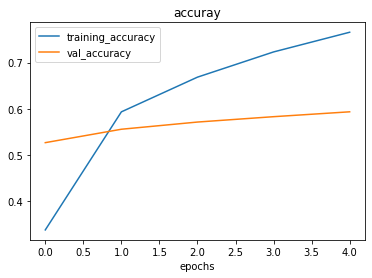

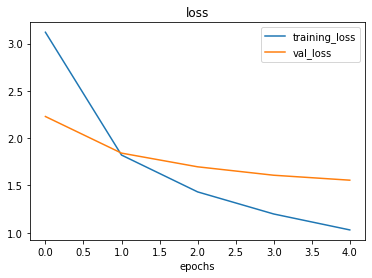

In [23]:
plot_loss_curves(history_model_1)

MODEL 2: WITH DATA AUGMENTATION

In [26]:
# Import the required modules for model creation
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"), # randomly flip images on horizontal edge
  preprocessing.RandomRotation(0.2), # randomly rotate images by a specific amount
  preprocessing.RandomHeight(0.2), # randomly adjust the height of an image by a specific amount
  preprocessing.RandomWidth(0.2), # randomly adjust the width of an image by a specific amount
  preprocessing.RandomZoom(0.2), # randomly zoom into an image
  # preprocessing.Rescaling(1./255) # keep for models like ResNet50V2, remove for EfficientNet. EfficienNet has it builds in
], name="data_augmentation")

In [29]:
# Setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer") # shape of input image
x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model(x, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
outputs = layers.Dense(len(train_data_10_percent.class_names), activation="softmax", name="output_layer")(x) # same number of outputs as classes
model_2 = tf.keras.Model(inputs, outputs)

In [30]:
model_2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-train

In [31]:
# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
                metrics=["accuracy"])

# Fit
history_model_2 = model_2.fit(train_data_10_percent,
                              epochs=5, # fit for 5 epochs to keep experiments quick
                              validation_data=test_data,
                              validation_steps=int(0.15 * len(test_data)), # evaluate on smaller portion of test data
                              callbacks=[checkpoint_callback]) # save best model weights to file
     

Epoch 1/5
237/237 [==============================] - 86s 339ms/step - loss: 3.3770 - accuracy: 0.2708 - val_loss: 2.4890 - val_accuracy: 0.4688
Epoch 2/5
237/237 [==============================] - 65s 272ms/step - loss: 2.2146 - accuracy: 0.4968 - val_loss: 2.0445 - val_accuracy: 0.5164
Epoch 3/5
237/237 [==============================] - 59s 246ms/step - loss: 1.8318 - accuracy: 0.5617 - val_loss: 1.8460 - val_accuracy: 0.5516
Epoch 4/5
237/237 [==============================] - 53s 224ms/step - loss: 1.6191 - accuracy: 0.6055 - val_loss: 1.7866 - val_accuracy: 0.5485
Epoch 5/5
237/237 [==============================] - 53s 221ms/step - loss: 1.4444 - accuracy: 0.6486 - val_loss: 1.7582 - val_accuracy: 0.5508


In [34]:
#to get actual validation score
model_2.evaluate(test_data)

790/790 [==============================] - 56s 71ms/step - loss: 1.5883 - accuracy: 0.5832


[1.5883342027664185, 0.5832475423812866]

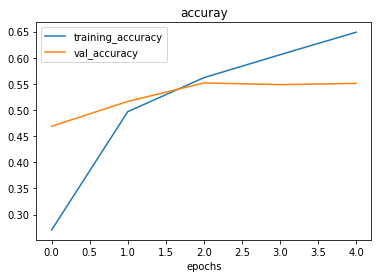

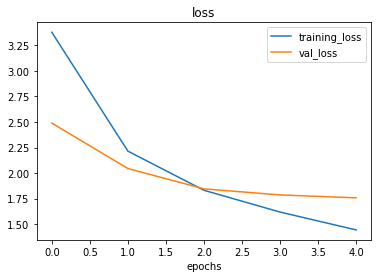

In [35]:
plot_loss_curves(history_model_2)

Although validation accuracy is a little worse than model_1 it seems like it will get better as model gets bigger.
Also, overfitting is reduced hovewer there is still overfitting.

MODEL_3: FINE TUNNING WITH DATA AUGMENTATION

In [36]:
#Make the last 5 layer trainable and other layers non-trainable in EfficientNetB0
base_model.trainable = True

for layer in base_model.layers[:-5]:
  layer.trainable = False

In [41]:
for layer in model_2.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 False
global_average_pooling True
output_layer True


In [44]:
model_2.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(1e-4), #10x lower then default parameter
                metrics = ['accuracy'])

FineTunned_history = model_2.fit(train_data_10_percent,
                                 steps_per_epoch = len(train_data_10_percent),
                                 epochs = 10,
                                 validation_data = test_data,
                                 validation_steps = int(0.15 * len(test_data)),
                                 initial_epoch = history_model_2.epoch[-1]) # start from previous last epoch

Epoch 5/10
237/237 [==============================] - 55s 206ms/step - loss: 1.2908 - accuracy: 0.6953 - val_loss: 1.7555 - val_accuracy: 0.5493
Epoch 6/10
237/237 [==============================] - 47s 195ms/step - loss: 1.2741 - accuracy: 0.6974 - val_loss: 1.7494 - val_accuracy: 0.5495
Epoch 7/10
237/237 [==============================] - 47s 198ms/step - loss: 1.2532 - accuracy: 0.7014 - val_loss: 1.7433 - val_accuracy: 0.5530
Epoch 8/10
237/237 [==============================] - 46s 190ms/step - loss: 1.2389 - accuracy: 0.7075 - val_loss: 1.7422 - val_accuracy: 0.5498
Epoch 9/10
237/237 [==============================] - 44s 184ms/step - loss: 1.2252 - accuracy: 0.7122 - val_loss: 1.7420 - val_accuracy: 0.5506
Epoch 10/10
237/237 [==============================] - 43s 180ms/step - loss: 1.2208 - accuracy: 0.7174 - val_loss: 1.7350 - val_accuracy: 0.5511


In [46]:
model_2.evaluate(test_data)

790/790 [==============================] - 57s 71ms/step - loss: 1.5400 - accuracy: 0.5958


[1.5400155782699585, 0.5958415865898132]

In [52]:
def compare_historys(original_history, new_history, initial_epochs=5):
    
    # Get original history measurements
    accuracy = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_accuracy = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = accuracy + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_accuracy + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots for accuracy
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')

    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    # Make plots for loss 
    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')

    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

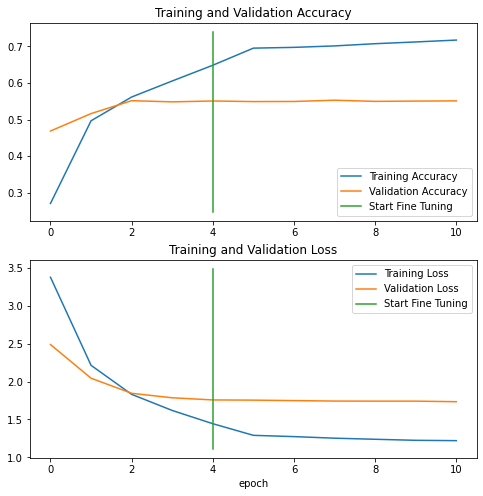

In [54]:
compare_historys(history_model_2, FineTunned_history, initial_epochs=5)

It seems that after fine-tuning, our model's training metrics improved significantly but validation, not so much. Looks like our model is starting to overfit.



In [55]:
pred_probs = model_2.predict(test_data, verbose = 1)

790/790 [==============================] - 67s 83ms/step


In [60]:
# Get the predicted classes
pred_classes = pred_probs.argmax(axis=1)

# Get the actual classes
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())

In [69]:
len(test_data.class_names), len(pred_classes), len(y_labels)

(101, 25250, 25250)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100]),
 <a list of 101 Text major ticklabel objects>)

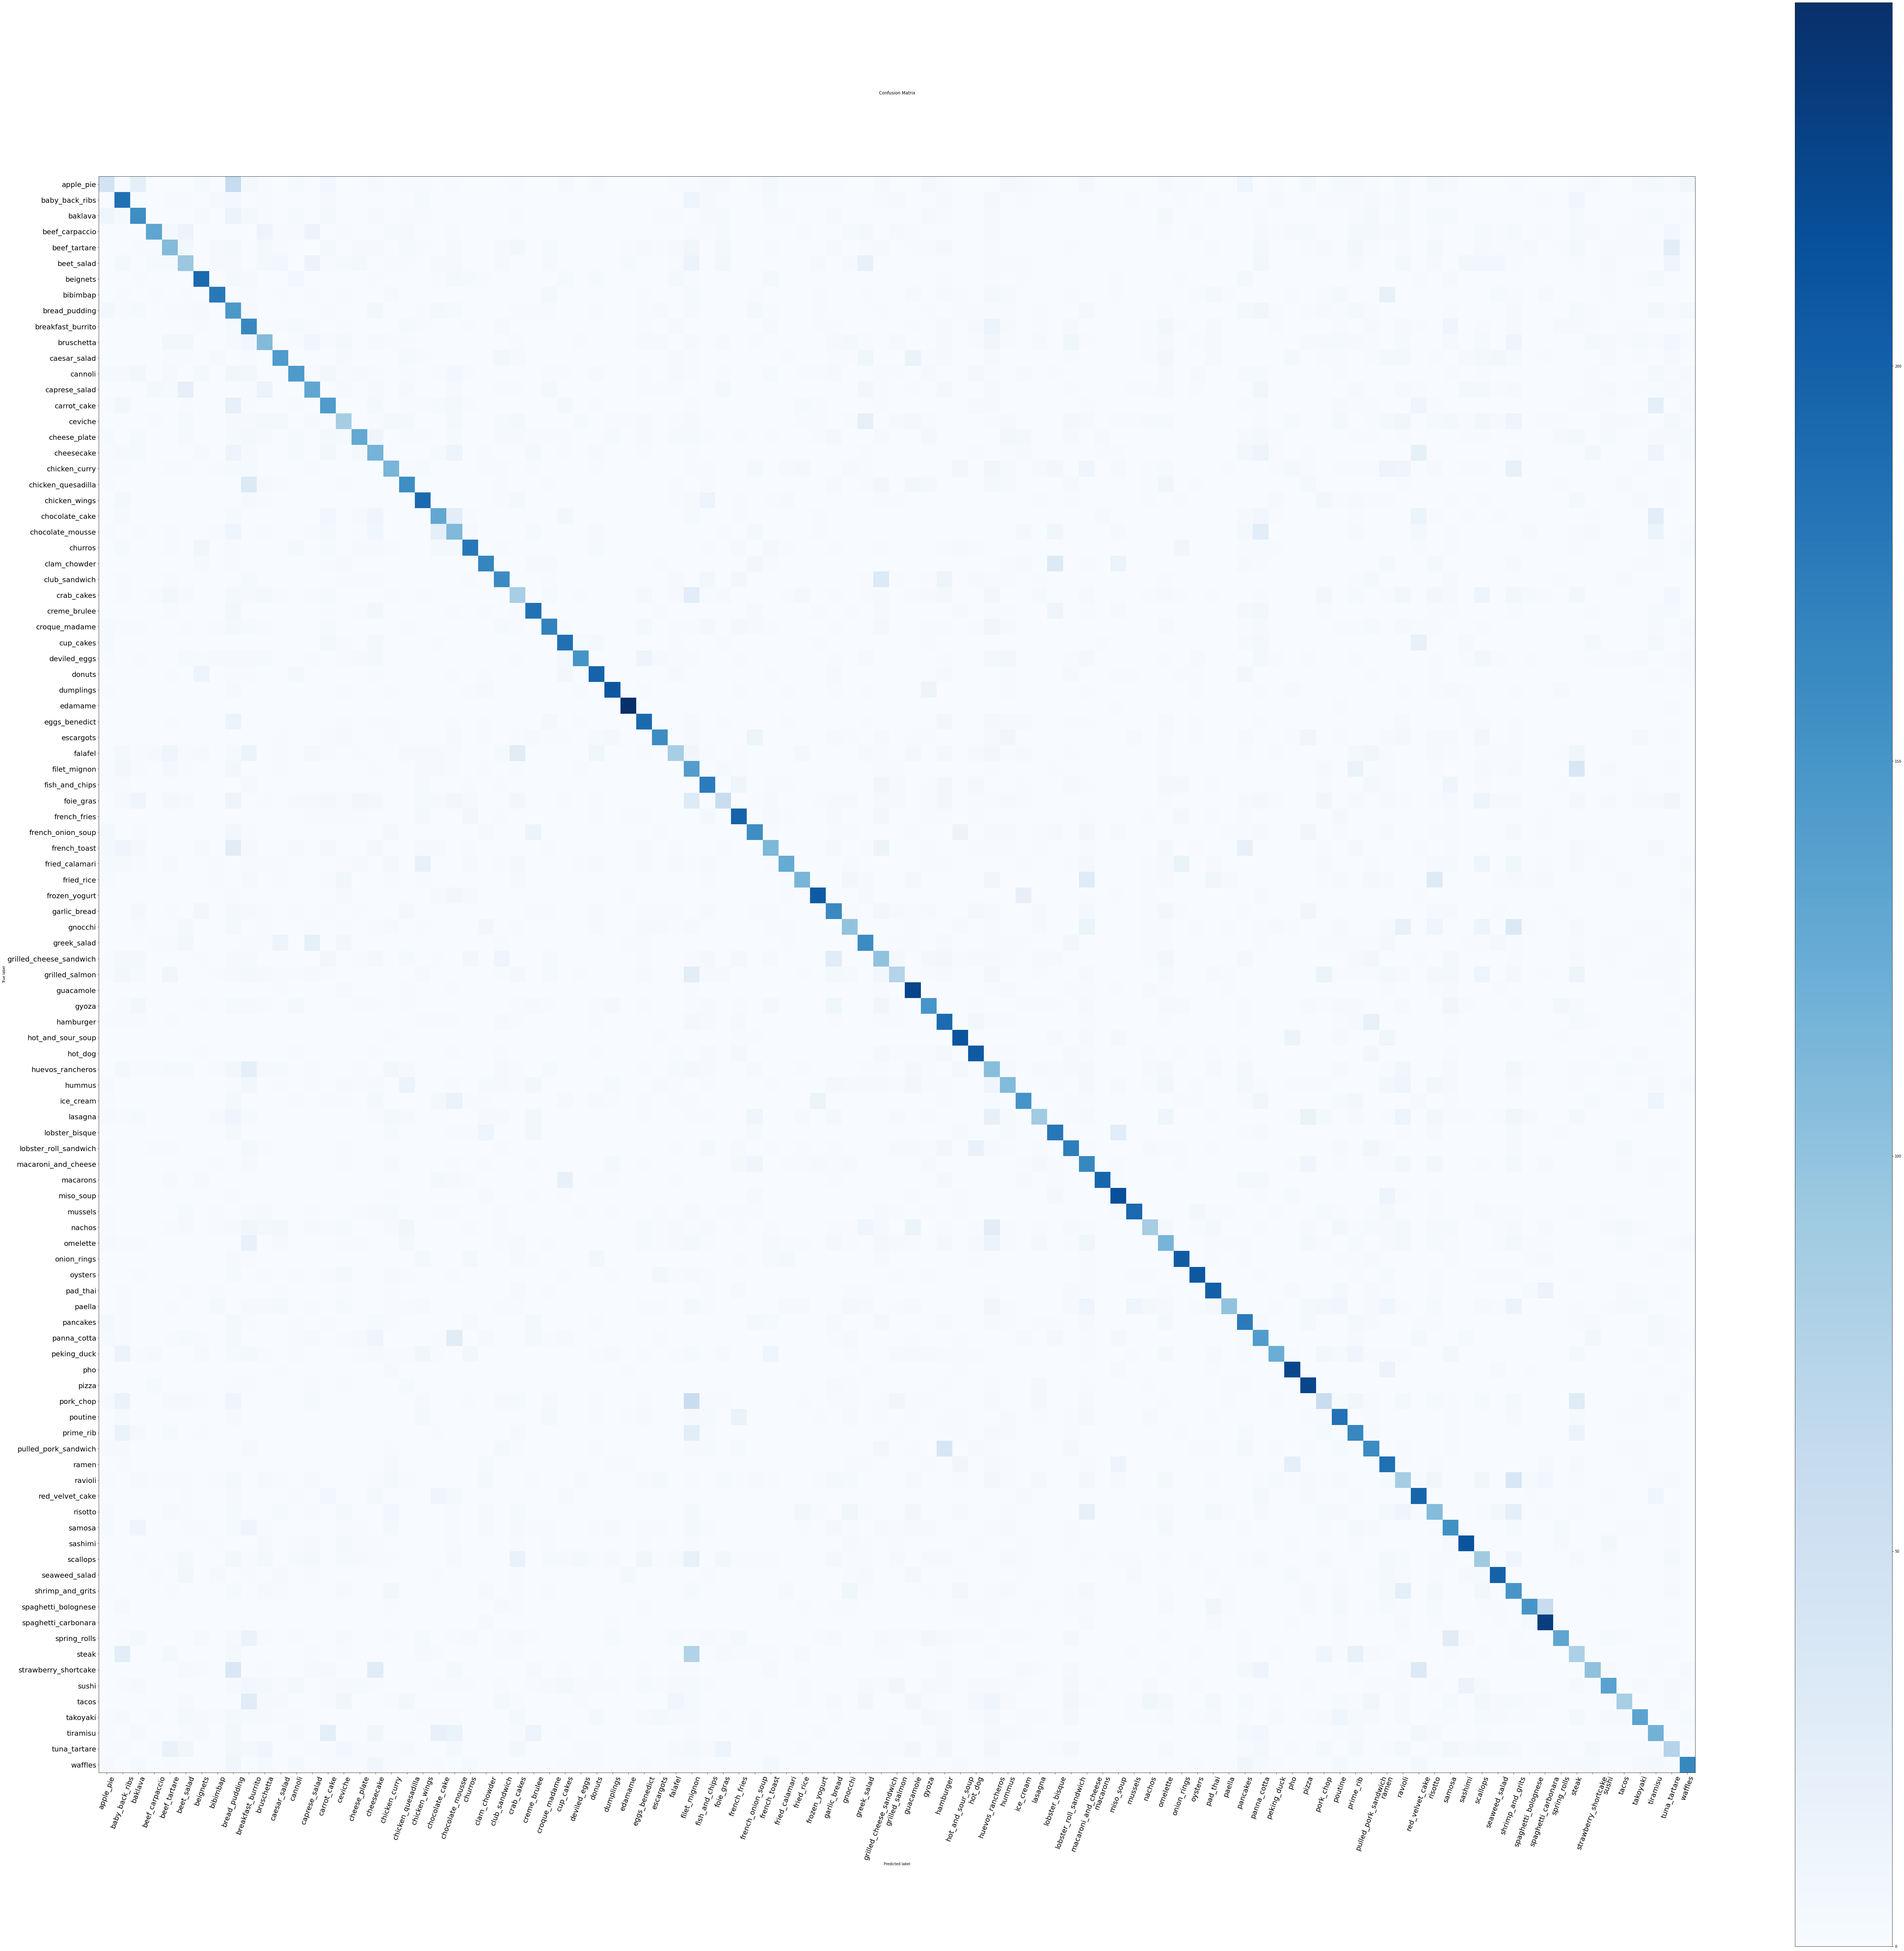

In [75]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

y_true=y_labels
y_pred=pred_classes

figsize=(100, 100)
text_size=20

# Create the confustion matrix
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
n_classes = cm.shape[0] # find the number of classes we're dealing with

# Plot the figure and make it pretty
fig, ax = plt.subplots(figsize=figsize)
cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
fig.colorbar(cax)

# Make x-axis labels appear on bottom
ax.xaxis.set_label_position("bottom")
ax.xaxis.tick_bottom()

# Label the axes
ax.set(title="Confusion Matrix",
        xlabel="Predicted label",
        ylabel="True label",
        xticks=np.arange(n_classes), # create enough axis slots for each class
        yticks=np.arange(n_classes), 
        xticklabels=test_data.class_names, # axes will labeled with class names (if they exist) or ints
        yticklabels=test_data.class_names)
  
# Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
plt.xticks(rotation=70, fontsize=text_size)
plt.yticks(fontsize=text_size)

GETTING THE ONES WITH BEST F1 SCORE

In [92]:
from sklearn.metrics import classification_report
import pandas as pd

class_f1_scores = {}

classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)

# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[test_data.class_names[int(k)]] = v["f1-score"]

f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores

,class_name,f1-score
33,edamame,0.962818
63,macarons,0.860927
69,oysters,0.847251
32,dumplings,0.844444
45,frozen_yogurt,0.831643
...,...,...
82,ravioli,0.321495
93,steak,0.304762
39,foie_gras,0.304000
77,pork_chop,0.276699


GETTING THE WRONG ONES WITH BEST F1 SCORE 
(In order to check manually why misprediction occurs)

In [95]:
# 1. Get the filenames of all of our test data
filepaths = []
for filepath in test_data.list_files("101_food_classes_10_percent/test/*/*.jpg", 
                                     shuffle=False):
  filepaths.append(filepath.numpy())

 # 2. Create a dataframe out of current prediction data for analysis
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [test_data.class_names[i] for i in y_labels],
                        "y_pred_classname": [test_data.class_names[i] for i in pred_classes]}) 

# 3. Is the prediction correct
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]

# 4. Get the top 100 wrong examples
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
23797,b'101_food_classes_10_percent/test/sushi/16593...,95,86,0.997505,sushi,sashimi,False
18001,b'101_food_classes_10_percent/test/pancakes/10...,72,67,0.981474,pancakes,omelette,False
14691,b'101_food_classes_10_percent/test/ice_cream/3...,58,79,0.980545,ice_cream,prime_rib,False
10847,b'101_food_classes_10_percent/test/fried_calam...,43,68,0.968668,fried_calamari,onion_rings,False
9326,b'101_food_classes_10_percent/test/filet_migno...,37,79,0.961560,filet_mignon,prime_rib,False
23631,b'101_food_classes_10_percent/test/strawberry_...,94,83,0.959269,strawberry_shortcake,red_velvet_cake,False
14255,b'101_food_classes_10_percent/test/hummus/1071...,57,49,0.959144,hummus,grilled_cheese_sandwich,False
11642,b'101_food_classes_10_percent/test/garlic_brea...,46,10,0.957134,garlic_bread,bruschetta,False
15359,b'101_food_classes_10_percent/test/lobster_rol...,61,53,0.953508,lobster_roll_sandwich,hamburger,False
4836,b'101_food_classes_10_percent/test/chicken_que...,19,9,0.950868,chicken_quesadilla,breakfast_burrito,False
